In [91]:
import requests
import pandas as pd

def get_ticker(stri):
    url = f'https://www.alphavantage.co/query?function=SYMBOL_SEARCH&keywords={stri}&apikey=DJ5ATAVVQLJE2IFG'
    r = requests.get(url)
    data = r.json()
    return str(pd.DataFrame(data["bestMatches"]).iloc[0][0])

def get_data(ticker="TIME_SERIES_INTRADAY",sym="IBM"):
    text="TIME_SERIES_INTRADAY"
    url = f"https://www.alphavantage.co/query?function={ticker}&symbol={sym}&interval=5min&apikey=DJ5ATAVVQLJE2IFG"
    r = requests.get(url)
    data = r.json()
    return data

def clean_col_names(df):
    for i in df.columns:
        df.rename(columns={i:i.split(sep=" ")[1].upper()}, inplace=True)
        df.index = pd.to_datetime(df.index)
        for i in df.columns:
            df[i]=pd.to_numeric(df[i])
    return df

def get_details(data):
    print(f'The {data["Meta Data"].get("1. Information")} with stock = {data["Meta Data"].get("2. Symbol")} was last refreshed at {data["Meta Data"].get("3. Last Refreshed")} with timezone = {data["Meta Data"].get("5. Time Zone")}')

def stock(data):
    print(f'{data["Meta Data"].get("2. Symbol")}')

data=get_data(ticker="TIME_SERIES_DAILY_ADJUSTED",sym=get_ticker(input()))
to_get=list(data)[1]

df = pd.DataFrame(data[to_get]).T
stock = stock(data)
clean_col_names(df)
get_details(data)

APLE
The Daily Time Series with Splits and Dividend Events with stock = APLE was last refreshed at 2023-06-20 with timezone = US/Eastern


In [92]:
df

,OPEN,HIGH,LOW,CLOSE,ADJUSTED,VOLUME,DIVIDEND,SPLIT
2023-06-20,15.14,15.1800,14.810,14.84,14.840000,1009231,0.00,1.0
2023-06-16,15.10,15.1600,14.920,15.14,15.140000,2484481,0.00,1.0
2023-06-15,15.12,15.1300,14.800,14.98,14.980000,1323267,0.00,1.0
2023-06-14,15.26,15.3300,15.025,15.18,15.180000,1243092,0.00,1.0
2023-06-13,15.36,15.5050,15.170,15.21,15.210000,1489970,0.00,1.0
...,...,...,...,...,...,...,...,...
2023-02-01,17.68,18.0150,17.515,17.87,17.498682,1387659,0.00,1.0
2023-01-31,17.43,17.8150,17.350,17.73,17.361591,1403045,0.00,1.0
2023-01-30,17.48,17.5959,17.320,17.40,17.038448,1330623,0.08,1.0
2023-01-27,17.44,17.6950,17.440,17.63,17.184659,1198355,0.00,1.0


### Another Model

In [112]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [113]:
data = df

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['CLOSE'].values.reshape(-1,1))
# Set the number of days used for prediction
prediction_days = 10

# Initialize empty lists for training data input and output
x_train = []
y_train = []

# Iterate through the scaled data, starting from the prediction_days index
for x in range(prediction_days, len(scaled_data)):
    # Append the previous 'prediction_days' values to x_train
    x_train.append(scaled_data[x - prediction_days:x, 0])
    # Append the current value to y_train
    y_train.append(scaled_data[x, 0])

# Convert the x_train and y_train lists to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape x_train to a 3D array with the appropriate dimensions for the LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

def LSTM_model():
    """
    Create and configure an LSTM model for stock price prediction.

    :return: The configured LSTM model (keras.Sequential)
    """

    # Initialize a sequential model
    model = Sequential()

    # Add the first LSTM layer with 50 units, input shape, and return sequences
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a second LSTM layer with 50 units and return sequences
    model.add(LSTM(units=50, return_sequences=True))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a third LSTM layer with 50 units
    model.add(LSTM(units=50))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a dense output layer with one unit
    model.add(Dense(units=1))

    return model

model = LSTM_model()
model.summary()
model.compile(
    optimizer='adam', 
    loss='mean_squared_error'
)
checkpointer = ModelCheckpoint(
    filepath = 'weights_best.hdf5', 
    verbose = 2, 
    save_best_only = True
)

model.fit(
    x_train, 
    y_train, 
    epochs=25, 
    batch_size = 32,
    callbacks = [checkpointer]
)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 10, 50)            10400     
                                                                 
 dropout_16 (Dropout)        (None, 10, 50)            0         
                                                                 
 lstm_19 (LSTM)              (None, 10, 50)            20200     
                                                                 
 dropout_17 (Dropout)        (None, 10, 50)            0         
                                                                 
 lstm_20 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_18 (Dropout)        (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                

4/4 [==============================] - 1s 5ms/step


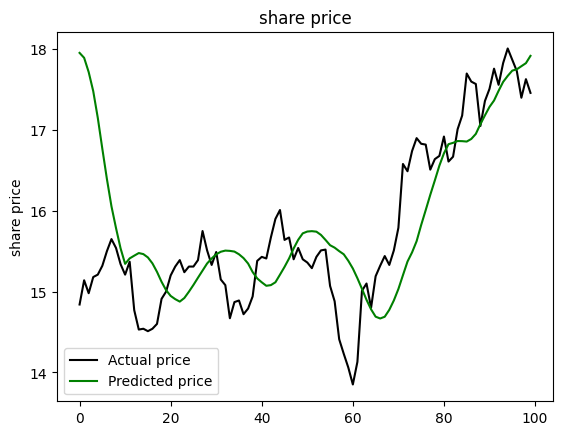

In [114]:
test_data=data
actual_prices = test_data['CLOSE'].values

# Concatenate the training and test data along the 'Close' column
total_dataset = pd.concat((data['CLOSE'], test_data['CLOSE']), axis=0)

# Extract the relevant portion of the dataset for model inputs
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values

# Reshape the model inputs to a 2D array with a single column
model_inputs = model_inputs.reshape(-1, 1)

# Apply the same scaling used for training data to the model inputs
model_inputs = scaler.transform(model_inputs)
x_test = []

# Iterate through the model inputs, starting from the prediction_days index
for x in range(prediction_days, len(model_inputs)):
    # Append the previous 'prediction_days' values to x_test
    x_test.append(model_inputs[x-prediction_days:x, 0])

# Convert the x_test list to a numpy array
x_test = np.array(x_test)

# Reshape x_test to a 3D array with the appropriate dimensions for the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Generate price predictions using the LSTM model
predicted_prices = model.predict(x_test)

# Invert the scaling applied to the predicted prices to obtain actual values
predicted_prices = scaler.inverse_transform(predicted_prices)
plt.plot(actual_prices, color='black', label=f"Actual price")

# Plot the predicted prices using a green linez
plt.plot(predicted_prices, color='green', label=f"Predicted price")

# Set the title of the plot using the company name
plt.title(f"share price")

# Set the x-axis label as 'time'
plt.xlabel(stock)

# Set the y-axis label using the company name
plt.ylabel(f"share price")

# Display a legend to differentiate the actual and predicted prices
plt.legend()

# Show the plot on the screen
plt.show()


In [115]:
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs + 1), 0]]

# Convert the real_data list to a numpy array
real_data = np.array(real_data)

# Reshape real_data to a 3D array with the appropriate dimensions for the LSTM model
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

# Generate a prediction using the LSTM model with the real_data input
prediction = model.predict(real_data)

# Invert the scaling applied to the prediction to obtain the actual value
prediction = scaler.inverse_transform(prediction)

# Print the prediction result to the console
print(f"Prediction: {prediction[0][0]}")

1/1 [==============================] - 1s 1s/step
Prediction: 17.504169464111328
